In [1]:
import os
import sys
sys.path.append('../code/')

from nn_models import *
from nn_train_utils import *
from kinematics_decoding import load_model
from tensorflow.python import pywrap_tensorflow
from collections import defaultdict
import glob
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

**Make sure that the validation/training accuracy and test accuracy are very similar.**

In [ ]:
conv_folders = glob.glob('../../nn-training/experiment_5/*_*_*')

conv_keylist = ['arch_type', 'nlayers', 'n_skernels', 'n_tkernels', 
                's_kernelsize', 't_kernelsize', 's_stride', 't_stride', 
                'validation_accuracy']

In [ ]:
conv_dict = defaultdict(list)

for folder in conv_folders:
    try:
        with open(os.path.join(folder, 'config.yaml')) as myfile:
            myconfig = yaml.load(myfile)    
    except:
        print(folder)    
    for key in conv_keylist:
        conv_dict[key].append(myconfig[key])

In [ ]:
all_conv_models = pd.DataFrame(conv_dict)

all_conv_models = all_conv_models.astype({'nlayers': int, 
                                          's_kernelsize':int, 
                                          't_kernelsize': int, 
                                          's_stride': int, 
                                          't_stride': int})

In [ ]:
# Load train dataset as test
PATH_TO_DATA = os.path.abspath('../../dataset/')
train_dataset = Dataset(os.path.join(PATH_TO_DATA, 'pcr_dataset_train.hdf5'), dataset_type='test', key='spindle_info')

conv_train_accuracies = [evaluate_model(
    load_model(all_conv_models.iloc[i], 5, 'conv', is_trained=True), train_dataset) for i in range(all_conv_models.shape[0])]

In [ ]:
# Load test dataset
PATH_TO_DATA = os.path.abspath('../../dataset/')
test_dataset = Dataset(os.path.join(PATH_TO_DATA, 'pcr_dataset_test.hdf5'), dataset_type='test', key='spindle_info')

conv_test_accuracies = [evaluate_model(
    load_model(all_conv_models.iloc[i], 5, 'conv', is_trained=True), test_dataset) for i in range(all_conv_models.shape[0])]

In [ ]:
conv_val_accuracies = all_conv_models['validation_accuracy'].tolist()
all_conv_models['test_accuracy'] = pd.Series(conv_test_accuracies, )
all_conv_models['train_accuracy'] = pd.Series(conv_train_accuracies)

In [ ]:
def num_parameters(model_path):
    path_to_ckptfile = os.path.join(model_path, 'model.ckpt')
    ckptReader = pywrap_tensorflow.NewCheckpointReader(path_to_ckptfile)
    shape_map = ckptReader.get_variable_to_shape_map()
    all_keys = list(shape_map.keys())
    weight_keys = [key for key in all_keys if 'weights' in key]
            
    useful_keys = [key for key in weight_keys if 'Adam' not in key]
    useful_keys = [key for key in useful_keys if 'Classifier' not in key]
    num_parameters = 0
    for key in useful_keys:
        num_parameters += np.product(shape_map[key])
        
    if num_parameters == np.nan:
        print('Number of parameters could not be computed!!')
        
    return num_parameters

num_pars_conv = []
for i in range(all_conv_models.shape[0]):
    mymodel = load_model(all_conv_models.iloc[i], 5, 'conv', True)
    num_pars_conv.append(num_parameters(mymodel.model_path))

all_conv_models['parameters'] = pd.Series(num_pars_conv, index=all_conv_models.index, dtype=int)

In [ ]:
all_conv_models.to_pickle('newconvmodels.p')

In [3]:
import pickle
a = pickle.load(open('convmodels.p', 'rb'))
b = pickle.load(open('newconvmodels.p', 'rb'))

Text(0.5,1,'Spatial-Temporal Nets')

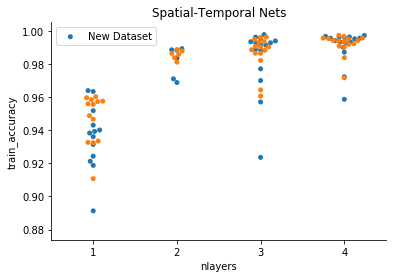

In [28]:
sns.swarmplot(x='nlayers', y='train_accuracy', data=b[b['arch_type'] == 'spatial_temporal'], color='C0')
sns.swarmplot(x='nlayers', y='train_accuracy', data=a[a['arch_type'] == 'spatial_temporal'], color='C1')
sns.despine()
plt.legend(['New Dataset'])
plt.title('Spatial-Temporal Nets')
# sns.swarmplot(x=a['nlayers']+0.4, y='test_accuracy', data=a[a['arch_type']=='spatial_temporal'], color='C1')

In [13]:
st_old = a[a['arch_type'] == 'spatiotemporal']
st_new = b[b['arch_type'] == 'spatiotemporal']

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:2019: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]


ValueError: x and y must have same first dimension, but have shapes (50,) and (48,)

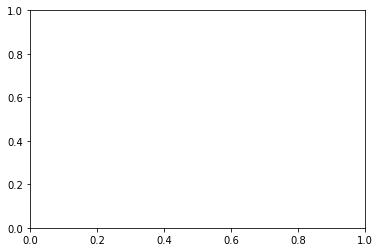

In [14]:
plt.plot(st_old['test_accuracy'], st_new['test_accuracy'], 'o', )
plt.plot([0.7, 1], [0.7, 1], 'k', linewidth=0.5)
sns.despine()
plt.ylabel('Test Accurcy with New Dataset')
plt.xlabel('Test Accuracy with Old Dataset')

In [ ]:
old_acc = np.array(st_old['test_accuracy'])
new_acc = np.array(st_new['test_accuracy'])
# Here, indices are basically network numbers

# Now we want a rank order for both
# Highest rank means best accuracy!
old_ranks = np.argsort(old_acc)
new_ranks = np.argsort(new_acc)
# Here indices are ranks, values are network numbers from before!

In [ ]:
# We want to plot this:
# If I have rank 1 in old, what rank do I have now?
corresponding_rank = [np.where(new_ranks==old_ranks[i])[0] for i in range(50)]

In [ ]:
plt.plot(corresponding_rank, 'o')
plt.plot([0, 50], [0, 50], 'k', linewidth=0.5)
sns.despine()
plt.xlabel('Rank with old test accuracy')
plt.ylabel('Rank with new test accuracy')

In [ ]:
plt.plot(b['parameters'], b['test_accuracy'], 'o')
plt.plot(a[a['arch_type']=='spatial_temporal']['parameters'], 
         a[a['arch_type']=='spatial_temporal']['test_accuracy'], 'o')
sns.despine()
plt.ylabel('Number of parameters')

In [ ]:
b.nlargest(50, 'test_accuracy')